# **Monitoring Melting Ice**
### **Part2** Distributed acoustic sensing applications to the cryosphere

### Introduction
In the previous notebook, we did single-station monitoring of permafrost at Mt. Zugspitze, using the station BW.ZUGS. In this notebook, we will look into distributed acoustic sensing (DAS), using a fiber which is deployed beneath the ridge of Mt. Zugspitze (see figure below). Compared to the single-station, DAS provides dense regular sampling of the ground motion, which can be exploited to calculate FK-spectra and analyze dispersion characteristics.

### Excercise
Here, we use pre-computed cross-correlations between station GIPL4 (see map below) and all DAS channels (~2m spacing along ~1km deployment) to calculate a FK-spectrum. As in the previous exercise, this notebook allows you to play around with the data selection. This time, you may choose different cable sections and/or different lag times of the cross-correlations. Play around with the data in order to extract surface wave dispersion characteristics.  

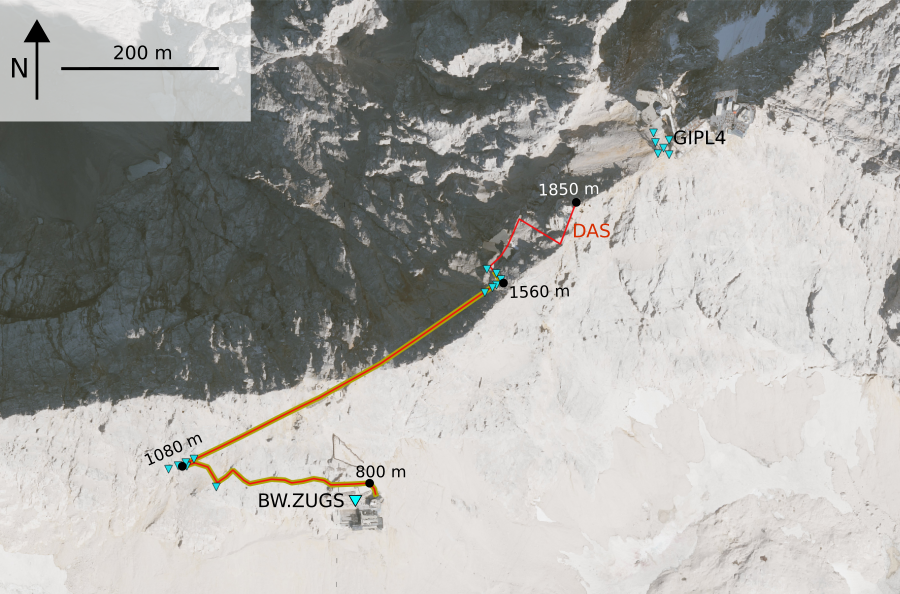

In [ ]:
#%matplotlib widget
import numpy as np
from obspy import read, Stream
from obspy.signal.util import next_pow_2
from fk import *
import matplotlib.pyplot as plt

#### Parameters

In [ ]:
comp = "RR"       # for cross-correlations between seismometer and DAS. Options are:
                  # ZR: vertical seismometer component cross-correlated with DAS channels
                  # RR: horizontal "radial" seismometer component, rotated to align with linear cable segment between 1080 and 1560 m
sta = "GIPL4"     # seismometer to be used - here, GIPL4 is the only available station
dstart = 1085.    # cable start distance used for fk-analysis
dend = 1555.      # cable end distance used for fk-analysis
tstart = -0.1     # min cross-correlation lag time used for fk-analysis
tend = 0.65        # max cross-correlation lag time used for fk-analysis
tp_space = 0.05   # percentage of the spatial domain that will be tapered at the edges
tp_time  = 0.1    # percentage of the time domain that will be tapered at the edges

#### Read the pre-computed cross-correlations

In [ ]:
# get seismometer-DAS cross-correlations
st = read(f"CCF/02/{sta}/{comp}/REF.MSEED").filter("bandpass", freqmin=0.1, freqmax=25, zerophase=True)

dt = st[0].stats.delta   # temporal sampling
dx = 2.0419039726257324  # spatial sampling

# make a plot to get an overview
fpmin = 2.   # min freq for plotting
fpmax = 12.  # max freq for plotting
vel = 2200.  # velocity moveout for plotting

stp = st.copy().filter("bandpass", freqmin=fpmin, freqmax=fpmax, zerophase=True)
datap = np.stack([tr.data / tr.data.max() for tr in stp])
tlag = stp[0].times() - stp[0].times().mean()
dist = np.arange(len(stp)) * dx + 800.

fig = plt.figure()
plt.pcolormesh(tlag, dist, datap, shading="auto", cmap="binary")
plt.axhline(dstart, linestyle="--", color="w", lw=1)
plt.axhline(dend, linestyle="--", color="w", lw=1)
plt.axvline(tstart, linestyle="--", color="w", lw=1)
plt.axvline(tend, linestyle="--", color="w", lw=1)

plt.plot(np.array([-1,0])+0.6,[vel,0], linestyle="--", color="r", lw=1, label=f"{vel} m/s")
plt.legend(fontsize=10)
plt.xlabel("lag time (s)")
plt.ylabel("distance along fiber (m)")
plt.title(f"cross-correlations between {sta} and DAS channels ({fpmin:.1f} - {fpmax:.1f} Hz)",
          fontsize=10)
plt.xlim(-5,5)
plt.ylim(dist.min(), dist.max())
plt.show()

#### For fk-analysis, use only the linear cable section with regular spatial sampling

In [ ]:
# select linear cable section
for tr in st:
    if tr.stats.station < "D%04i" % dstart or tr.stats.station > "D%04i" % dend:
        st.remove(tr)
        
# select specified lag time range        
idxl = np.where((tlag >= tstart) & (tlag <= tend))
dist = np.arange(len(st)) * dx + dstart
data = np.stack([tr.data[idxl] / tr.data[idxl].max() for tr in st])

# apply taper in the spatial and temporal domain
for i in range(data.shape[1]):
    data[:,i] = taper_array(data[:,i], dx, max_percentage=tp_space)
for i in range(data.shape[0]):
    data[i,:] = taper_array(data[i,:], dt, max_percentage=tp_time)
    
fig = plt.figure(figsize=(4,5))
plt.pcolormesh(tlag[idxl], dist, data, cmap="binary", shading="auto",
               vmin=-data.max(), vmax=data.max())
plt.xlim(-2,2)
plt.ylabel("distance along fiber (m)")
plt.xlabel("lag time (s)")
plt.title("data selection for fk-spectrum", fontsize=10)
plt.show()

#### Calculate fk-spectrum

In [ ]:
# zero-pad the time and space domain to an arbitrary number of samples in analogy to 1D Fourier transform
#nx_padto = next_pow_2(data.shape[0])
#nt_padto = next_pow_2(data.shape[1])
nx_padto = 3000
nt_padto = 3000

# calculate the FK-spectrum
data_fk = np.fft.fftshift(np.fft.fft2(data, s=(nx_padto,nt_padto)))
f_axis = np.fft.fftshift(np.fft.fftfreq(nt_padto, d=dt))
k_axis = np.fft.fftshift(np.fft.fftfreq(nx_padto, d=dx))

#### Plot the FK-spectrum and dispersion

In [ ]:
# slice data to speed-up plotting
idxf = np.where((f_axis >= -30.) & (f_axis <= 30.))[0]
idxk = np.where((k_axis >= -0.05) & (k_axis <= 0.05))[0]
fp = f_axis[idxf]
kp = k_axis[idxk]
datap_fk = data_fk[idxk[:,None],idxf]
del idxf, idxk


# scale FK-spectrum
#fk = 20*np.log10((abs(datap_fk)/abs(datap_fk).max()))
fk = (abs(datap_fk) / abs(data_fk).max())

# get meshgrids
ff, kk = np.meshgrid(fp, kp)
# select only 1. quadrant and calculate dispersion using c = f/k
idxf = np.where(fp >= 0)[0]
idxk = np.where(kp >= 0)[0]
ff_q1 = ff[idxk[:,None],idxf]
kk_q1 = kk[idxk[:,None],idxf]
kk_q1[kk_q1==0] = 1e-9  # prevent divide by 0
fk_q1 = fk[idxk[:,None],idxf]
cc_q1 = ff_q1 / kk_q1   # dispersion

# scales for pcolormesh
#vmax = 0
#vmin = -15
vmin = None
vmax = None

# figure
fig = plt.figure(figsize=(10,4))

# axis 1: FK-spectrum
ax1 = fig.add_subplot(121)
ax1.pcolormesh(ff, kk, fk, cmap="CMRmap", shading="auto", vmin=vmin, vmax=vmax)
ax1.plot(vel*k_axis, k_axis, "w--", lw=1, label=f"{vel} m/s")
ax1.set_ylim(-0.05,0.05)
ax1.set_xlim(-25,25)
ax1.set_ylabel("wavenumber (1/m)")
ax1.set_xlabel("frequency (Hz)")
ax1.set_title("FK-spectrum", fontsize=10)
plt.legend(fontsize=10)

# axis 2: dispersion
ax2 = fig.add_subplot(122)
im = ax2.pcolormesh(ff_q1, cc_q1, fk_q1, cmap="CMRmap", shading="auto", vmin=vmin, vmax=vmax)
plt.colorbar(im)
ax2.axhline(vel, linestyle="--", color="w")
ax2.set_ylim(500, 5000)
ax2.set_xlim(0,25)
ax2.set_ylabel("phase velocity (m/s)")
ax2.set_xlabel("frequency (Hz)")
ax2.set_title("dispersion", fontsize=10)

plt.show()